In [66]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk



C:\Users\HP\AppData\Local\Temp\ipykernel_130388\2133259644.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = INTERVAL, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


Coefficient: [-1.99174639e-06]
Intercept: 0.00021645976234582222
R2 : 0.00010952023434496194


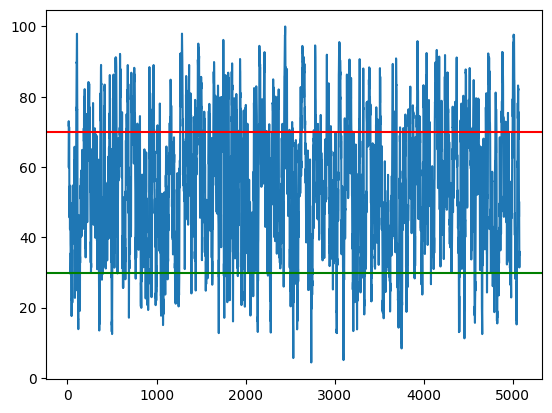

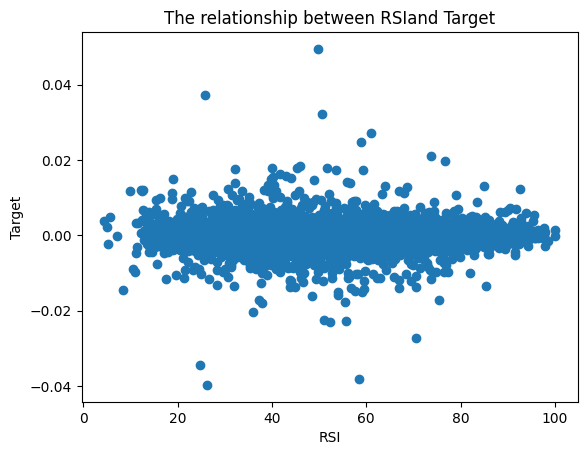

In [70]:
TICKER = 'SPY'
LOOKBACK = 10000
INTERVAL = '1h'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

#Set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
#what subsection of data are you interested in


def get_data(ticker = TICKER, lookback =  LOOKBACK, interval = INTERVAL):

    #get data at interval you want
    df = yf.download(ticker, interval = INTERVAL, period = PERIOD) 
    df.columns = df.columns.get_level_values(0)

    #reset the index to make plots prettier
    df = df.reset_index(drop = True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called the dependent variable, or y)
def add_target(df, shift = SHIFT):

    #What is the close price SHIFT days from now
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    #what is the change in close price SHIFT days from now
    df ['Target'] = (df[f'Close + {shift}'] - df ['Close']) / df['Close']


    return df

def add_RSI(df, length = RSI_LENGTH):
    price_change = df['Close'].diff()
    # separategains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0) #negative sign i crucial to factor in loss

    # average gain vs loss
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    rs= avg_gain/avg_loss
    rsi = 100 - (100 /(1 + rs))

    df['RSI'] = rsi

    #plot thenrelative strength index
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green')

    return df.dropna()

def generate_regression_output(df, features = 'RSI', target ='Target'):

    subset = df[[features, target]].dropna()

    #reshape for sklearn
    X = df[[features]].values #2d
    y = df[target].values #1d

    model = sk.linear_model.LinearRegression()
    model.fit(X, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(X)

    r2 = sk.metrics.r2_score(y, y_pred)

    #coef, intercept, r2 ... use later on
    print(f'Coefficient: {model.coef_}')
    print(f'Intercept: {model.intercept_}')
    print(f'R2 : {r2}')

    #plot a relationship betweeen feature and target
    plt.figure()
    plt.title(f'The relationship between {features}and {target}')
    plt.scatter(X, y)
    plt.xlabel(f'{features}')
    plt.ylabel(f'{target}')

    return df


def main():
    df = get_data(TICKER)
    df = add_target(df, shift = SHIFT)
    df = add_RSI(df, length = RSI_LENGTH)
    df = generate_regression_output(df, features = 'RSI', target ='Target')
    return df

df = main()


In [68]:
df.tail(300)

Price,Close,High,Low,Open,Volume,Close + 1,Target,RSI
4777,675.340027,676.534973,674.614990,675.969971,14041621,677.440002,0.003110,28.658707
4778,677.440002,678.090027,674.169983,674.979980,16529139,678.289978,0.001255,40.638433
4779,678.289978,678.398499,676.760010,677.434998,7754225,680.045898,0.002589,37.783665
4780,680.045898,680.099976,678.085022,678.270020,6475145,680.409973,0.000535,41.785877
4781,680.409973,680.859924,679.940002,680.049988,6079943,680.210022,-0.000294,39.893101
...,...,...,...,...,...,...,...,...
5072,689.080017,689.974976,688.510010,689.650024,9738248,689.349976,0.000392,50.174644
5073,689.349976,690.085022,688.440002,689.080017,6230622,689.500000,0.000218,43.690255
5074,689.500000,690.614990,688.789978,689.349976,6161020,688.919983,-0.000841,42.056882
5075,688.919983,689.804993,688.280029,689.500000,5132226,689.575012,0.000951,31.438411
